In [1]:
# import some necessary stuff

In [2]:
# from dask.distributed import Client

# client = Client("tcp://10.32.15.52:42529")
# client

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from dask.distributed import Client

client = Client("tcp://10.32.15.112:39707")
client

Client Scheduler: tcp://10.32.15.112:39707 Dashboard: /user/0000-0003-0487-8518/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [5]:
%matplotlib inline
import xarray as xr
import intake
import util
import warnings
from cmip6_preprocessing.preprocessing import read_data

/srv/conda/envs/notebook/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['stac-catalog', 'stac-collection', 'stac-item'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


In [6]:
if util.is_ncar_host():
    col = intake.open_esm_datastore("../catalogs/glade-cmip6.json")
else:
    col = intake.open_esm_datastore("../catalogs/pangeo-cmip6.json")
col

pangeo-cmip6-ESM Collection with 28691 entries:
	> 10 activity_id(s)

	> 23 institution_id(s)

	> 48 source_id(s)

	> 29 experiment_id(s)

	> 86 member_id(s)

	> 23 table_id(s)

	> 190 variable_id(s)

	> 7 grid_label(s)

	> 28691 zstore(s)

	> 59 dcpp_init_year(s)

In [8]:
# read all data with volume and oxygen
with warnings.catch_warnings(): # these lines just make sure that the warnings dont clutter your notebook
    warnings.simplefilter("ignore")
    data_dict = read_data(col,
                    experiment_id=['historical'],
                    grid_label='gn',
                    variable_id=['o2','thkcello', 'areacello'],
                    member_id = 'r1i1p1f1', # so that this runs faster for testing
                    required_variable_id = ['o2', 'thkcello', 'areacello']
                    )

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 2 group(s)
--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 6 group(s)
--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 10 group(s)
CanESM5
NON-REFERENCE MODE. This should just be used for a bunch of variables on the same grid
IPSL-CM6A-LR
NON-REFERENCE MODE. This should just be used for a bunch of variables on the same grid


In [10]:
import numpy as np
from xhistogram.xarray import histogram
def omz_volume(o2, vol, o2_bins, dim=['x', 'y', 'olevel']):
    nanmask = np.isnan(o2)
    # Should we also check the bin data for nans?
    full_sum = histogram(
        o2.where(~nanmask),
        bins=[o2_bins],
        weights=vol.where(~nanmask),
        dim=dim,
    )
    return full_sum

In [11]:
#o2_bins = np.arange(0,300,10)
#ds_test = data_dict['IPSL-CM6A-LR']
#vol = ds_test.areacello * ds_test.thkcello
#o2 = ds_test.o2 * 1e3 # convert to mumol

#omz_vol = omz_volume(o2, vol, o2_bins)

In [26]:
o2_bins = np.arange(0,100,5)
ds_test = data_dict['IPSL-CM6A-LR']
ds_test = ds_test.chunk({'time': 20,'x': -1,'y': -1, 'lev': -1})
vol = ds_test.thkcello
o2 = ds_test.o2 * 1e3 # convert to mumol

omz_space = omz_volume(o2, vol, o2_bins,['lev'])

In [27]:
omz_space_cum = omz_space.cumsum('o2_bin')

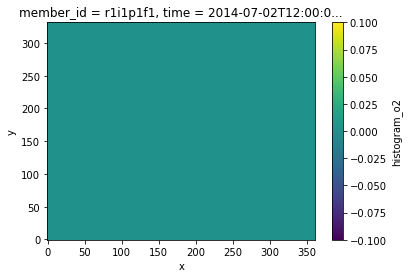

In [28]:
omz_space_cum.isel(time = -1,o2_bin = 12).plot()

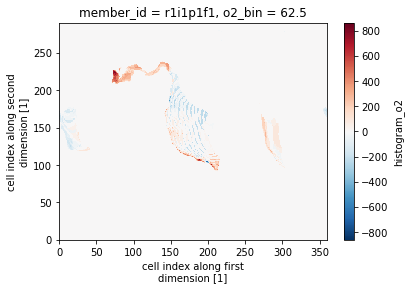

In [24]:
omz_60 = omz_space_cum.sel(o2_bin=60, method='nearest')

(omz_60.isel(time = -1)-omz_60.isel(time = 0)).plot()

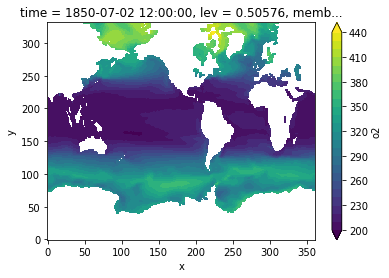

In [23]:
o2.isel(time = 0,lev = 0).plot(levels = np.arange(200,450,10))

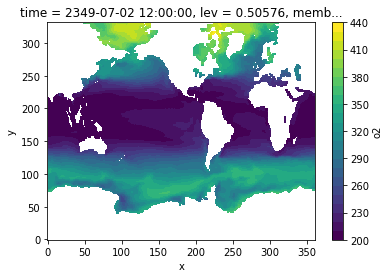

In [22]:
o2.isel(time = -1,lev = 0).plot(levels = np.arange(200,450,10))

In [13]:
omz_vol = omz_vol.chunk({'time': 20})

In [14]:
omz_80 = omz_vol.cumsum('o2_bin').sel(o2_bin=80, method='nearest')

In [ ]:
omz_80.plot()